In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/networkLab/Train_data.csv')

In [ ]:
test=pd.read_csv('/content/drive/MyDrive/networkLab/Test_data.csv')

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.shape

(25192, 42)

In [ ]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

In [ ]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


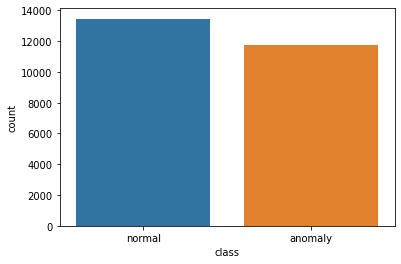

In [ ]:
sns.countplot(x=train['class'])

In [ ]:
print('Class distribution Training set:')
print(train['class'].value_counts())

Class distribution Training set:
normal     13449
anomaly    11743
Name: class, dtype: int64


In [ ]:
def levelEncode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

levelEncode(train)
levelEncode(test)

In [ ]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [ ]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [ ]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate']

In [ ]:
X_train = X_train[selected_features]

In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [ ]:
x_train.shape

(17634, 10)

In [ ]:
x_test.shape

(7558, 10)

In [ ]:
y_train.shape

(17634,)

In [ ]:
y_test.shape

(7558,)

In [ ]:
import time

In [ ]:
from sklearn.linear_model import LogisticRegression

clfl = LogisticRegression(max_iter = 1200000)
start_time = time.time()
clfl.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.06140446662902832


In [ ]:
start_time = time.time()
y_test_pred = clfl.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.004714488983154297


In [ ]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9418169445389588
Test Score: 0.938872717650172


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00


In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.978433448002117], datetime_start=datetime.datetime(2023, 2, 10, 13, 56, 22, 651795), datetime_complete=datetime.datetime(2023, 2, 10, 13, 56, 24, 196889), params={'KNN_n_neighbors': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9783940115685608
Test Score: 0.978433448002117


In [ ]:
from sklearn.tree import DecisionTreeClassifier

clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.027809858322143555


In [ ]:
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.0018613338470458984


In [ ]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.9951045250066155], datetime_start=datetime.datetime(2023, 2, 10, 13, 56, 28, 456456), datetime_complete=datetime.datetime(2023, 2, 10, 13, 56, 28, 510080), params={'dt_max_depth': 15, 'dt_max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=14, value=None)


In [ ]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9997731654757854
Test Score: 0.9949722148716592


In [ ]:
data = [["Logistic Regression", lg_train, lg_test],
        ["KNN", KNN_train, KNN_test],
        ["Decision Tree", dt_train, dt_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ Logistic Regression │      0.941817 │     0.938873 │
├─────────────────────┼───────────────┼──────────────┤
│ KNN                 │      0.978394 │     0.978433 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999773 │     0.994972 │
╘═════════════════════╧═══════════════╧══════════════╛


In [ ]:
SEED = 42

# Decision Tree Model
dtc = DecisionTreeClassifier()

# KNN
knn = KNeighborsClassifier()

# LOGISTIC REGRESSION MODEL

lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import cross_val_score
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [ ]:
scores = {}
for name in models:
  scores[name]={}
  for scorer in ['precision','recall']:
    scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)

In [ ]:
def line(name):
  return '*'*(25-len(name)//2)

for name in models:
  print(line(name), name, 'Model Validation', line(name))

  for scorer in ['precision','recall']:
    mean = round(np.mean(scores[name][scorer])*100,2)
    stdev = round(np.std(scores[name][scorer])*100,2)
    print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
    print()

*************** KNeighborsClassifier Model Validation ***************
Mean precision: 
 98.39 % +- 0.41

Mean recall: 
 98.3 % +- 0.44

**************** LogisticRegression Model Validation ****************
Mean precision: 
 93.57 % +- 0.63

Mean recall: 
 95.64 % +- 0.6

************** DecisionTreeClassifier Model Validation **************
Mean precision: 
 99.45 % +- 0.24

Mean recall: 
 99.51 % +- 0.19



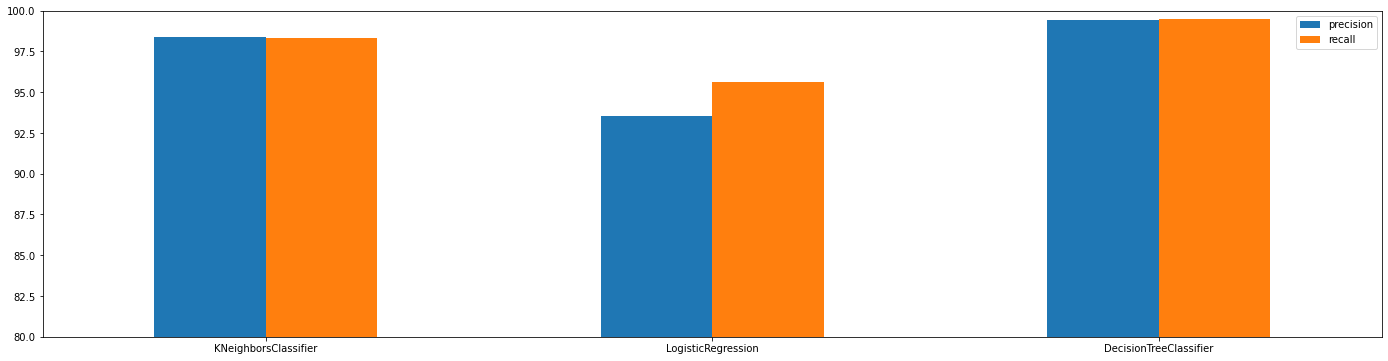

In [ ]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)

In [ ]:
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [ ]:
preds={}
for name in models:
    models[name].fit(x_train, y_train)
    preds[name] = models[name].predict(x_test)
print("Predictions complete.")

Predictions complete.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["normal","anamoly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

*************** KNeighborsClassifier Model Testing ***************
[[3423   75]
 [  57 4003]]
---------------
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98      3498
     anamoly       0.98      0.99      0.98      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558

**************** LogisticRegression Model Testing ****************
[[3224  274]
 [ 188 3872]]
----------------
              precision    recall  f1-score   support

      normal       0.94      0.92      0.93      3498
     anamoly       0.93      0.95      0.94      4060

    accuracy                           0.94      7558
   macro avg       0.94      0.94      0.94      7558
weighted avg       0.94      0.94      0.94      7558

************** DecisionTreeClassifier Model Testing **************
[[3476   22]
 [  22 4038]]
--------------
              pr

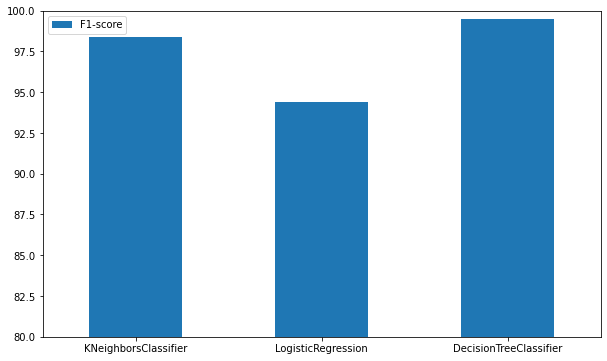

In [ ]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
f1s.plot(kind = "bar",  ylim=[80,100], figsize=(10,6), rot=0)